# Optimisation avec l'algorithme EGO

The EGO algorithm [jones1998] is an adaptative optimization method based on kriging. An initial design of experiment is used to build a first metamodel. At each iteration a new point that maximizes a criterion is chosen as optimizer candidate. The criterion uses a tradeoff between the metamodel value and the conditional variance. Then the new point is evaluated using the original model and the metamodel is relearnt on the extended design of experiment.

L'objectif de cet exemple est de montrer le comportement de l'algorithme sur un exemple unidimensionnel.

## Description of the method

We chose the point so as to maximize an improvement criterion based on the metamodel.

Assume that $g:\mathbb{R}^p \rightarrow \mathbb{R}$ is a function with vector input and scalar output. 

Suppose that we already have a set of points $\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n \in\mathbb{R}^p$. 
Based on this design of experiments, we have created a kriging metamodel which prediction is the expected value of the Gaussian process, denoted by $m_k(\boldsymbol{x})$ associated with a conditional standard deviation $s_K(\boldsymbol{x})$:

$$
\tilde{g}(\boldsymbol{x}) = m_k(\boldsymbol{x})
$$

for any $\boldsymbol{x} \in\mathbb{R}^p$ where $m_K(\boldsymbol{x})$ is the mean of the Gaussian process:

$$
Y(\boldsymbol{x}) \sim \mathcal{N}(m_k(\boldsymbol{x}),s_K(\boldsymbol{x})^2).
$$

Denote by $g_{min}$ the minimum function value achieved so far:

$$
g_{min} = \min(g(\boldsymbol{x}_1),\ldots, g(\boldsymbol{x}_n) \in\mathbb{R}.
$$

Suppose that we wish to improve this value and get an even lower function value. We would need to predict a point $\boldsymbol{x}_{new}$ such that:

$$
g(\boldsymbol{x}_{new}) < g_{min}.
$$

But we do not want to evaluate $g(\boldsymbol{x}_{new})$, because this may cost a large amount of CPU time. Therefore, we replace this function $g$ by its surrogate $\tilde{g}$. This amounts to search for $\boldsymbol{x}_{new}$ such that:

$$
\tilde{g}(\boldsymbol{x}_{new}) < g_{min}.
$$

We see that the next point will be selected provided that $g_{min} - \tilde{g}(\boldsymbol{x}_{new}) > 0$. 
If this criterion is not met, the next point would be so that the function value is increased. 

Our Gaussian regression process, however, does not only predict the value $\tilde{g}(\boldsymbol{x}_{new})$ but also its uncertainty, represented by the Gaussian random variable $Y(\boldsymbol{x}_{new})$. This is why we are searching for $\boldsymbol{x}_{new}$ such that we increase the probability of the event:

$$
g_{min} - Y(\boldsymbol{x}_{new}) > 0.
$$

This is why the next point $\boldsymbol{x}_{new}$ is selected so as to maximise the function:

$$
I(\boldsymbol{x}_{new}) = \textrm{max}(g_{min} - Y(\boldsymbol{x}_{new}), 0)
$$

where $Y(\boldsymbol{x}_{new})$ is the Gaussian random variable:

$$
Y(\boldsymbol{x}_{new}) \sim \mathcal{N}\left(m_k(\boldsymbol{x}_{new}),s_K(\boldsymbol{x}_{new})^2\right). 
$$

Since $Y_{new}$ is a random variable, so is the criterion. This is why we consider its expected value. 
The *expected improvement* (EI) aims at maximizing the mean improvement:

$$
\mathbb{E}\left[I(x_{new})\right] = \mathbb{E}\left[\textrm{max}(g_{min} - Y_{new}(\boldsymbol{x}_{new}), 0)\right]
$$

The trick is that the random variable $Y_{new}$ is a Gaussian random variable, which leads to a way to compute this criteria based on the properties of the Gaussian distribution.

The criterion that we want to maximise is:

$$
EI(\boldsymbol{x}_{new}) = \mathbb{E}\left[I(\boldsymbol{x}_{new})\right] 
$$
where:
$$
\mathbb{E}\left[I(\boldsymbol{x}_{new})\right]
= (g_{min} - m_K(\boldsymbol{x}_{new})) \Phi\left( \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right) 
+ s_K(\boldsymbol{x}_{new}) \phi\left( \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right)
$$

for any $\boldsymbol{x}_{new} \in\mathbb{R}^p$, 
where $\Phi$ is the cumulative distribution function (CDF) of the standard Gaussian distribution and $\phi$ is its probability density function (PDF).

The next point is then the solution of the optimization problem:
$$
x_{new}^\star = \textrm{argmax}_{\boldsymbol{x}_{new}\in\mathbb{R}^p} EI(\boldsymbol{x}_{new}).
$$

## The exploitation - exploitation tradeoff

Let $Z_{new}$ be defined by:
$$
Z_{new} := \frac{Y(\boldsymbol{x}_{new}) - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})}.
$$

The properties of the Gaussian distribution are so that:

$$
Z_{new} \sim \mathcal{N}(0,1).
$$

Hence, 

\begin{align*}
&\mathbb{P}(Y(\boldsymbol{x}_{new}) < g_{min}) \\
&= \mathbb{P}\left( \frac{Y_{new} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} 
\leq \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right) \\
&= \Phi\left( \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right).
\end{align*}

The expression of the EI criterion can be decomposed in two parts.

The first part:

$$
(g_{min} - m_K(\boldsymbol{x}_{new})) \Phi\left( \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right) 
$$

is lower when the point $\boldsymbol{x}_{new}$ is in a region where the kriging prediction $m_K(\boldsymbol{x}_{new})$ is low and the probability of improvement is large. 

It is the product of two sub-expressions that we now analyze. When $m_K(\boldsymbol{x}_{new})$ decreases, then $g_{min} - m_K(\boldsymbol{x}_{new})$ increases. 
Furthermore, when the probability of the event $Y_{new} < g_{min}$ increases, then the criterion increases too.

The first part then favors the search of a point which are close to the minimum values of the kriging metamodel, which is the "exploitation" part of the method. 

The second part of the criterion:

$$
s_K(\boldsymbol{x}_{new}) \phi\left( \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right)
$$

favors the regions where the uncertainty of the model is large. 

This is the product of two subexpressions. The expression $s_K(\boldsymbol{x}_{new})$ represents the error of the kriging metamodel. When it is large, so is the uncertainty on $Y_{new}$. The second part $\phi\left( \frac{g_{min} - m_K(\boldsymbol{x}_{new})}{s_K(\boldsymbol{x}_{new})} \right)$ is larger when the current value of the metamodel is close to the current optimum value. Therefore, the second part of the criterion is larger in the regions where the model uncertainty is larger: this is the "exploration" part of the method.

The EI criterion performs a trade-off between a local exploitation and a global exploration of the model.


## Bibliography

* Donald R. Jones, Matthias Schonlau and William J Welch. Global optimization of expensive black-box functions, Journal of Global Optimization, 13(4), 455-492, 1998.
* http://openturns.github.io/openturns/master/auto_numerical_methods/optimization/plot_ego.html

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np

In [2]:
ot.RandomGenerator.SetSeed(0)

We begin by creating the model. This is the function $g:[0,12] \rightarrow \mathbb{R}$ defined by the equation:

$$
g(x) = 10 + x + \frac{x^2}{20} + 2 x \sin(x)
$$

for any $x\in[0,1]$.
It is the sum of the quadratic polynomial $10 + x + \frac{x^2}{20}$ and the wave $\sin(x)$ with increasing magnitude $2x$.

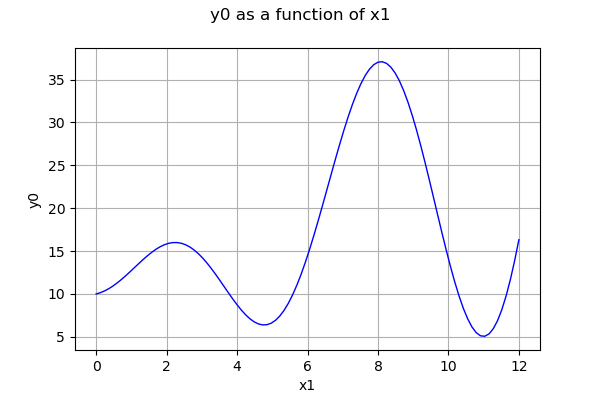

In [3]:
dim = 1
model = ot.SymbolicFunction(["x1"], ["10.0 + x1 + x1^2 / 20 + 2.0 * x1 * sin(x1)"])
model = ot.MemoizeFunction(model)
graph = model.draw(0.0, 12.0, 100)
graph

Our goal is to find the minimum of the function:

$$
x^\star = \textrm{argmin}_{x\in[0,12]} g(x).
$$

We see that the minimum is located near $x=11$, where the function value is close to $g(x)=5$.

We then define the optimization problem. We choose a uniform distribution in the range from 0 to 12:

$$
X \sim \mathcal{U}(0,12).
$$

In [4]:
bounds = ot.Interval([0.0] * dim, [12.0] * dim)
problem = ot.OptimizationProblem()
problem.setObjective(model)
problem.setBounds(bounds)
distribution = ot.ComposedDistribution([ot.Uniform(0.0, 12.0)] * dim)

In order to create the kriging metamodel, we must estimate its coefficients on a design of experiments (DOE). To keep it simple, we consider below the Monte-Carlo DOE (but a LHS or an optimized LHS may improve the fit).

In [5]:
sample_size = 5
experiment = ot.MonteCarloExperiment(distribution, sample_size)
inputSample = experiment.generate()
print(inputSample)
outputSample = model(inputSample)
print(outputSample)

    [ X0        ]
0 : [  7.55852  ]
1 : [ 10.5937   ]
2 : [  1.62332  ]
3 : [  0.390033 ]
4 : [  4.16468  ]
    [ y0       ]
0 : [ 34.8771  ]
1 : [  6.70594 ]
2 : [ 14.9972  ]
3 : [ 10.6942  ]
4 : [  7.92095 ]


Notice that the best function value so far is $g(x)=6.706$ achieved at $x=10.59$.

The central piece is the kriging metamodel that we now build. We use a Gaussian process with a squared exponential covariance model, which produces very regular trajectories (infinitely differentiable). The trend is based on a constant basis.

In [6]:
covarianceModel = ot.SquaredExponential([2.0] * dim, [0.1])
basis = ot.ConstantBasisFactory(dim).build()
kriging = ot.KrigingAlgorithm(inputSample, outputSample, covarianceModel, basis)
kriging.run()
krigingResult = kriging.getResult()

We check the predictivity capabilities of the metamodel with the `MetaModelValidation` class, which allows to visually check the metamodel. To do this, we use cross-validation, which involve a test DOE.

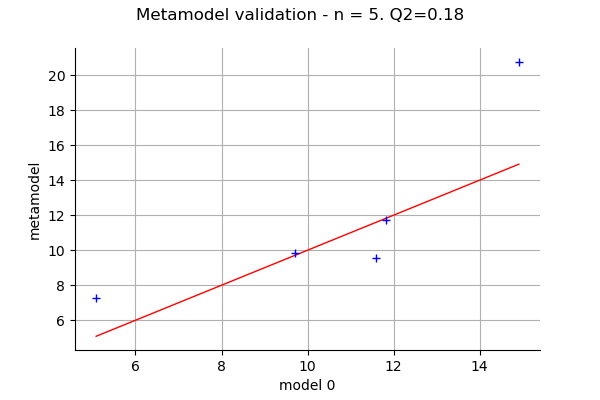

In [7]:
metamodel = krigingResult.getMetaModel()
inputSampleTest = experiment.generate()
outputSampleTest = model(inputSampleTest)
validation = ot.MetaModelValidation(inputSampleTest, outputSampleTest, metamodel)
graph = validation.drawValidation()
Q2 = validation.computePredictivityFactor()
title = graph.getTitle()
title += ". Q2=%.2f" % (Q2[0])
graph.setTitle(title)
graph

This DOE does not seem to be very accurate: some points are very distant to the diagonal of the graph. The predictivity coefficient Q2 would not be sufficient to approximate the minimum of the function by the minimum of the metamodel. 

This is why we iteratively add new points to the DOE with the EGO algorithm. We perform only one iteration of the algorithm, by evaluating the `setMaximumEvaluationNumber(1)` method.

In [8]:
model.getEvaluationCallsNumber()

110

In [9]:
algo = ot.EfficientGlobalOptimization(problem, krigingResult)
algo.setMaximumEvaluationNumber(1)
algo.run()
result = algo.getResult()
xStar = result.getOptimalPoint()
print("x*=", xStar[0])
optimalValue = result.getOptimalValue()
print("g(x*)=", optimalValue[0])

x*= 10.593662684631123
g(x*)= 6.705935945342805


This is shows that the minimum has not changed: the best function value is still $g(x)=6.706$, the same already observed in the training set. The EGO criterion was not able to improve the situation with one single evaluation.

In [10]:
model.getEvaluationCallsNumber()

111

This solution was produced after searching for the maximum of the EI criterion. This criterion was reached for the input point $x_{new}$ and can be retrieved by the `getInputSample` method. 

In [11]:
xnew = result.getInputSample()
xnew

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=1 data=[[11.7972]]

The point selected by the EGO criterion $x=11.80$  is very close to the right of the $[0,12]$ domain.

In [12]:
ynew = result.getOutputSample()
ynew

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=1 data=[[12.3452]]

This corresponds to the function value on the right of the domain.

In [13]:
model(xnew)

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=1 description=[y0] data=[[12.3452]]

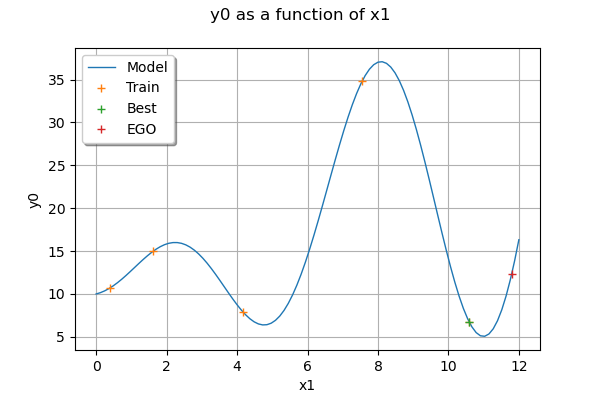

In [14]:
graph = model.draw(0.0, 12.0, 100)
graph.setLegends(["Model"])
cloud = ot.Cloud(inputSample, outputSample)
cloud.setLegend("Train")
graph.add(cloud)
cloud = ot.Cloud([xStar], [optimalValue])
cloud.setLegend("Best")
graph.add(cloud)
cloud = ot.Cloud(xnew, ynew)
cloud.setLegend("EGO")
graph.add(cloud)
graph.setColors(ot.Drawable_BuildDefaultPalette(4))
graph.setLegendPosition("topleft")
graph

The training set contained already a very good point at $x=10.59$. The EGO criterion selects the point $x=11.80$. 

In order to see what happened, we create a few drawing functions.

In [15]:
def linearSample(xmin, xmax, npoints):
    """Returns a sample created from a regular grid
    from xmin to xmax with npoints points."""
    step = (xmax - xmin) / (npoints - 1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices


def plot_kriging_bounds(vLow, vUp, n_test):
    """
    From two lists containing the lower and upper bounds of the region,
    create a PolygonArray.
    """
    palette = ot.Drawable.BuildDefaultPalette(1)
    myPaletteColor = palette[0]
    polyData = [[vLow[i], vLow[i + 1], vUp[i + 1], vUp[i]] for i in range(n_test - 1)]
    polygonList = [
        ot.Polygon(polyData[i], myPaletteColor, myPaletteColor)
        for i in range(n_test - 1)
    ]
    boundsPoly = ot.PolygonArray(polygonList)
    boundsPoly.setLegend("95% bounds")
    return boundsPoly


def plotMyBasicKriging(krigResult, model, xMin, xMax, X, Y, level=0.95):
    """
    Given a kriging result, plot the data, the kriging metamodel
    and a confidence interval.
    """
    samplesize = X.getSize()
    meta = krigResult.getMetaModel()
    graphKriging = meta.draw(xMin, xMax)
    graphKriging.setLegends(["Kriging"])
    # Create a grid of points and evaluate the function and the kriging
    nbpoints = 50
    xGrid = linearSample(xMin, xMax, nbpoints)
    yFunction = model(xGrid)
    yKrig = meta(xGrid)
    # Compute the conditional covariance
    epsilon = ot.Point(nbpoints, 1.0e-8)
    conditionalVariance = krigResult.getConditionalMarginalVariance(xGrid) + epsilon
    conditionalVarianceSample = ot.Sample([[cv] for cv in conditionalVariance])
    conditionalSigma = np.sqrt(conditionalVarianceSample)
    # Compute the quantile of the Normal distribution
    alpha = 1 - (1 - level) / 2
    quantileAlpha = ot.DistFunc.qNormal(alpha)
    # Graphics of the bounds
    epsilon = 1.0e-8
    dataLower = [
        yKrig[i, 0] - quantileAlpha * conditionalSigma[i, 0] for i in range(nbpoints)
    ]
    dataUpper = [
        yKrig[i, 0] + quantileAlpha * conditionalSigma[i, 0] for i in range(nbpoints)
    ]
    # Coordinates of the vertices of the Polygons
    vLow = [[xGrid[i, 0], dataLower[i]] for i in range(nbpoints)]
    vUp = [[xGrid[i, 0], dataUpper[i]] for i in range(nbpoints)]
    # Compute the Polygon graphics
    boundsPoly = plot_kriging_bounds(vLow, vUp, nbpoints)
    boundsPoly.setLegend("95% bounds")
    # Validate the kriging metamodel
    mmv = ot.MetaModelValidation(xGrid, yFunction, meta)
    Q2 = mmv.computePredictivityFactor()[0]
    # Plot the function
    graphFonction = ot.Curve(xGrid, yFunction)
    graphFonction.setLineStyle("dashed")
    graphFonction.setColor("magenta")
    graphFonction.setLineWidth(2)
    graphFonction.setLegend("Function")
    # Draw the X and Y observed
    cloudDOE = ot.Cloud(X, Y)
    cloudDOE.setPointStyle("circle")
    cloudDOE.setColor("red")
    cloudDOE.setLegend("Data")
    # Assemble the graphics
    graph = ot.Graph()
    graph.add(graphFonction)
    graph.add(cloudDOE)
    graph.add(graphKriging)
    graph.setLegendPosition("bottomright")
    graph.add(boundsPoly)
    graph.setAxes(True)
    graph.setGrid(True)
    graph.setTitle("Size = %d, Q2=%.2f%%" % (samplesize, 100 * Q2))
    graph.setXTitle("X")
    graph.setYTitle("Y")
    return graph

The following plot presents the kriging metamodel based on the initial 5 points. We see that the metamodel, that is, the expected value of the Gaussian process, is already quite accurate. There are, however, still large uncertainties of the predicted function value in some zones where the function has a large curvature, e.g. at points $x=3$ or $x=6$.

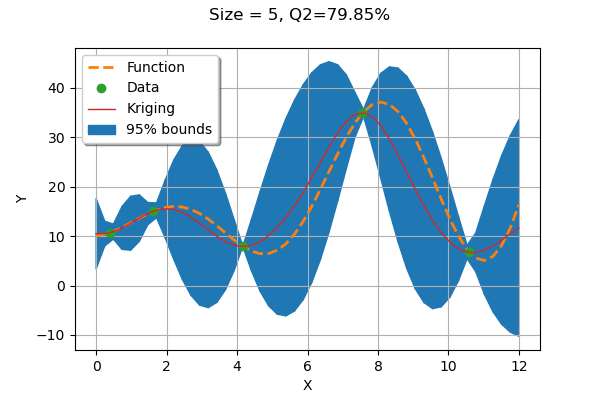

In [16]:
graph = plotMyBasicKriging(krigingResult, model, 0.0, 12.0, inputSample, outputSample)
graph.setLegendPosition("topleft")
palette = ot.Drawable_BuildDefaultPalette(5)
graph.setColors(palette[1:4])
graph

We see that the EGO criterion selected the region near $x=12$, where both the uncertainty is large and the potential value of the function could be low.

In order to see the criterion that the EGO algorithm maximizes, we analyse it in more details.

The following `ExpectedImprovementEvaluation` class evaluates the EI criterion depending on the current optimal value $g_{min}$ and the current kriging metamodel.

In [17]:
class ExpectedImprovementEvaluation(ot.OpenTURNSPythonFunction):
    """Defines the expected improvement criterion."""

    def __init__(self, optimalValue, krigingResult):
        """
        Create a ExpectedImprovementEvaluation.

        Parameters
        ----------
        optimalValue : float
            The best value so far.
        krigingResult : ot.KrigingResult
            The kriging metamodel.

        Returns
        -------
        None.
        """
        metamodel = krigingResult.getMetaModel()
        inputDimension = metamodel.getInputDimension()
        super(ExpectedImprovementEvaluation, self).__init__(inputDimension, 1)
        self.optimalValue = optimalValue
        self.krigingResult = krigingResult

    def _exec(self, x):
        """
        Evaluate the EI function at point x.

        Parameters
        ----------
        x : ot.Point
            The input point.

        Returns
        -------
        expectedImprovement : ot.Point(1)
            The value of the expected improvement.

        """
        mx = self.krigingResult.getConditionalMean(x)[0]
        fmMk = self.optimalValue - mx
        sk2 = self.krigingResult.getConditionalMarginalVariance(x)
        sk = np.sqrt(sk2)
        ratio = fmMk / sk
        ei = fmMk * ot.DistFunc.pNormal(ratio) + sk * ot.DistFunc.dNormal(ratio)
        return [ei]

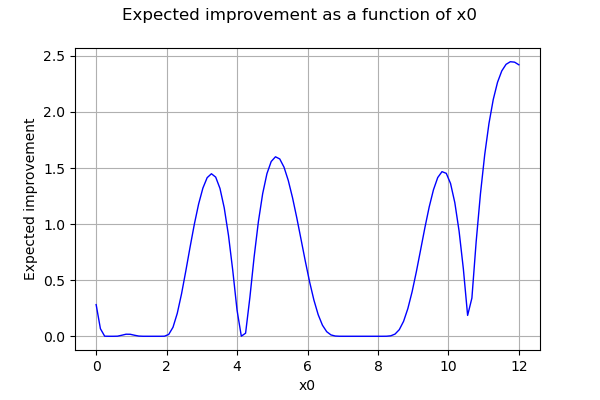

In [18]:
evaluationEI = ExpectedImprovementEvaluation(optimalValue[0], krigingResult)
functionEI = ot.Function(evaluationEI)
functionEI.setInputDescription(krigingResult.getMetaModel().getInputDescription())
functionEI.setOutputDescription(["Expected improvement"])

graph = functionEI.draw(0.0, 12.0, 100)
graph

We see that the average chance of improving the criterion is small on the left of the domain. The expected improvement is large for $x$ close to $x\approx3$ or $x\approx5$, but the largest value is reach for $x\approx12$. This corresponds to the $x_{new}=11.79$ value that we found previously.